In [1]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import h5py
import fn_HAZUS_loss 
%matplotlib inline

In [2]:
# Load mat data 
hf = h5py.File('hazardEpistemicData.h5', 'r')
# rename weight vector to avoid ambiguity
wtHaz = hf.get('wt')
lambda_x = hf.get('lambda_x')

x = np.logspace(np.log10(0.05), np.log10(2), num=100)

In [3]:
# Fragility function specification
betaIM = 0.4
thetaIM = [0.4, 0.6]
wtTheta = [0.5, 0.5]
fragility = []
for j in range(len(thetaIM)):
    fragility.append(norm.cdf(np.log(x), np.log(thetaIM[j]), betaIM))


In [4]:
# Risk calculations over all logic tree branches
failRate = []
wtMaster = []
for i in range(wtHaz.size):  # loop over hazard curve branches
    dLambda =  np.abs(np.diff(lambda_x[i]).tolist() + [0])  # derivative of hazard curve              
    
    for j in range(len(thetaIM)): # loop over fragility branches
        failRate.append(np.sum(fragility[j] * dLambda))
        wtMaster.append(wtHaz[i] * wtTheta[j])
                      

In [5]:
# Mean hazard and mean fragility
lambdaImMean = []
fragilityMean = []
for k in range(x.size):
    lambdaImMean.append(np.sum(lambda_x[:,k] * wtHaz))  # mean hazard
    fragilityMean.append(np.sum(np.array(fragility)[:,k] * wtTheta))  # mean fragility

dLambdaMean =  np.abs(np.diff(lambdaImMean).tolist() + [0])  # derivative of mean hazard curve
failRateMeanInputs = np.sum(fragilityMean * dLambdaMean)  # failure rate using mean hazard and mean fragility


Text(0, 0.5, 'Cumulative probability')

<Figure size 432x288 with 0 Axes>

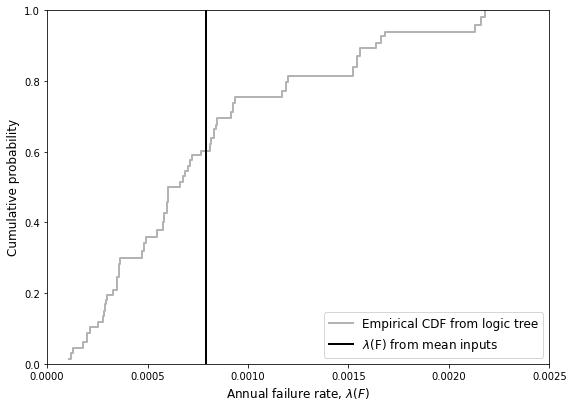

In [6]:
# Fractiles of failure rate

# fractiles of hazard
dataIDX = np.argsort(failRate)
failRateSort = sorted(failRate) # order branches from lowest rate to highest
wtMasterSort = np.array(wtMaster)[dataIDX]
weightCum = np.cumsum(wtMasterSort) # order weights appropriately, and cumulatively sum

# Plot Fig 9.13
plt.figure(1)
plt.figure(figsize=(9, 6.5))
plt.step(failRateSort, weightCum, where='post', label='Empirical CDF from logic tree', linewidth=2, color=[0.7, 0.7, 0.7])
plt.plot([failRateMeanInputs,failRateMeanInputs], [0, 1], linestyle='-', linewidth=2, color=[0, 0, 0], label='$\lambda$(F) from mean inputs')
plt.legend(loc='lower right', fontsize=12)
plt.ylim(0, 1)
plt.xlim(0,2.5e-3)
plt.xlabel('Annual failure rate, $\lambda(F)$', fontsize=12)
plt.ylabel('Cumulative probability', fontsize=12)

In [7]:
# Bar chart of failure rate
xInt = 0.2e-3 # width of intervals to plot
xPlot = np.arange(xInt/2, 13*xInt, step=xInt) # IM intervals to plot
yPlot = []
failRate = np.array(failRate)
for i in range(xPlot.size):
    idx = np.where((failRate>=(xPlot[i]-xInt/2)) & (failRate<(xPlot[i]+xInt/2)))
    yPlot.append(np.sum(np.array(wtMaster)[idx])) # sum weights of branches that fall in this bin

<Figure size 432x288 with 0 Axes>

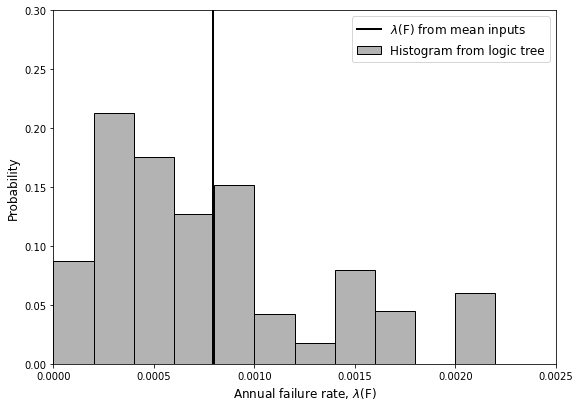

In [8]:
# Plot Fig 9.14
plt.figure(2)
plt.figure(figsize=(9, 6.5))
plt.bar(xPlot, yPlot, width=0.0002, edgecolor='k', color=[0.7, 0.7, 0.7], label='Histogram from logic tree')
plt.plot([failRateMeanInputs, failRateMeanInputs], [0, 0.3], '-k', linewidth=2, label='$\lambda$(F) from mean inputs')
plt.xlabel('Annual failure rate, $\lambda$(F)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xlim(0, 2.5e-3)
plt.ylim(0, 0.3)
plt.legend(loc='upper right', fontsize=12)

In [9]:
# Double-lognormal fragility model
mu_lnTheta = (np.log(thetaIM[0]) + np.log(thetaIM[1]))/2
thetaMedian = np.exp(mu_lnTheta)
betaTheta = np.sqrt(((np.log(thetaIM[0])-mu_lnTheta)**2 + (np.log((thetaIM[1]))-mu_lnTheta)**2)/2)
betaTot = np.sqrt(betaIM**2 + betaTheta**2)

failRateDoubleLog = np.sum(norm.cdf(np.log(x), np.log(thetaMedian), betaTot) * dLambdaMean) # failure rate using mean hazard and double-lognormal fragility

failRateMedianFragility = np.sum(norm.cdf(np.log(x), np.log(thetaMedian), betaIM) * dLambdaMean) # failure rate using mean hazard and fragility with no epistemic


(0.0, 1.0)

<Figure size 432x288 with 0 Axes>

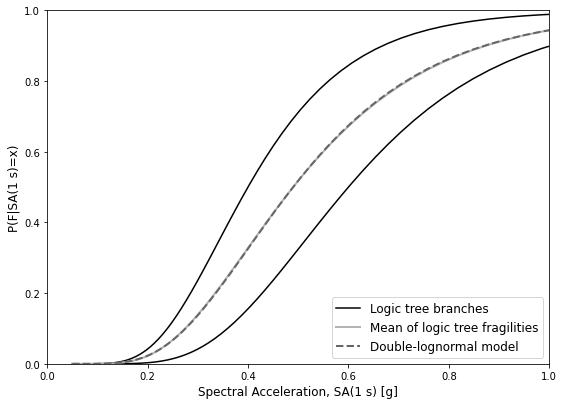

In [10]:
# Fragility functions plot
# Plot Fig 9.15
plt.figure(3)
plt.figure(figsize=(9, 6.5))
plt.plot(x, fragility[0], color='k', label='Logic tree branches')
plt.plot(x, fragility[1], color='k')
plt.plot(x,fragilityMean, linewidth=2, color=[0.7, 0.7, 0.7], label='Mean of logic tree fragilities')
plt.plot(x,norm.cdf(np.log(x), np.log(thetaMedian), betaTot), linestyle='--', linewidth=2, color=[0.4, 0.4, 0.4], label='Double-lognormal model')
plt.legend(loc='lower right', fontsize=12)
plt.xlabel('Spectral Acceleration, SA(1 s) [g]', fontsize=12)
plt.ylabel('P(F|SA(1 s)=x)', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)